# Exploration of the Embeddings

The embeddedings were created using the embedding API by openai. 
The strings comprised of the dataset title, description, and long
description (or whatever data there was available from those 
categories).

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
#| export
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA

In [ ]:
# Import embeddings (done on the strings created for each dataset) and performing mean normalisation
embeddings_df = pd.read_json('~/database_compendium/data/final_embeddings.json')
normalised_df = (embeddings_df-embeddings_df.mean())/embeddings_df.std()

In [ ]:
# Performing PCA keeping at least 80% of the explained variance
pca = PCA(n_components=73)
cols = ['PC' + str(i) for i in range(73)]
principalComponents = pca.fit_transform(normalised_df.T)
principal_df = pd.DataFrame(principalComponents, columns=cols)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)
cum_var = round(max(cumulative_var_ratio)*100, 1)
print(f"The principal components explain {cum_var}% of the variance")

The principal components explain 80.2% of the variance


In [ ]:
# Adding the dataset titles back after PCA
principal_df.insert(0, 'Dataset_title', list(embeddings_df.columns))
principal_df.head(3)

Dataset_title       PC0       PC1  \
0            Quarterly personal well-being estimates  6.663733  0.048016   
1   Personal well-being estimates by local authority  6.755539  0.300209   
2  Deaths registered weekly in England and Wales ...  9.521175 -1.462629   

        PC2       PC3       PC4       PC5       PC6       PC7       PC8  ...  \
0  3.370242  4.024503  0.225782  2.551249  0.463104 -3.311750 -1.934044  ...   
1  3.718559  3.469152 -0.125358  2.784452  0.447448 -3.485710 -1.972821  ...   
2  3.615774  2.398188 -0.797274  0.828975  1.372468 -0.354584 -3.900317  ...   

       PC63      PC64      PC65      PC66      PC67      PC68      PC69  \
0  0.143386  1.751496 -0.690980  0.496997  2.996164  0.270318  1.390910   
1  0.494378  1.159898 -0.333956  1.309263  2.726666 -0.226505  0.889379   
2 -0.134441  1.876576  0.976360 -1.615926  0.002844 -0.849112  1.558708   

       PC70      PC71      PC72  
0  1.767697 -0.237612  1.573346  
1  2.009549 -0.441216  2.075843  
2  0.430748 -0.996233  2.741432  

[3 rows x 74 columns]

In [ ]:
# Plotting the data in terms of the first two principal components
fig = px.scatter(principal_df, 
                 x='PC0', y='PC1', 
                 hover_data={'Title': list(principal_df.iloc[:, 0])})

fig.layout.height = 500
fig.show()

## Data Similarity
Using cosine similarity and SVM to calculate the similarity between datasets.

In [ ]:
#| export
def cos_similarity(data, # Dataset as a dataframe that we want to use to compare rows
                   compare_row=0, # The row in the dataset that will be compared with all the others
                   num=10): # The number of similar datasets that will be returned (in descending order)

    """Using cosine similarity to find the most closely related datasets"""

    if type(data.iloc[0, 0]) == str:
        labels = data.iloc[:, 0]
        vectors = data.iloc[:, 1:]
    else:
        labels = data.index.values
        vectors = data.iloc[:, :]
        
    query = vectors.iloc[compare_row, :].values
    vectors = vectors.drop(compare_row).values
    # print(query[:5])
    # print(vectors[0][:5])
    
    """ 
    Calculate the cosine similarity between the query vector and each embedding vector
    and sort in descending order.
    
    https://github.com/karpathy/randomfun/blob/master/knn_vs_svm.ipynb
    """
    similarities = vectors.dot(query) # This gives inconsistent results!!
    sorted_ix = np.argsort(-similarities)
                           
    updated_labels = labels
    del updated_labels[compare_row]
    updated_labels = list(updated_labels)

    return [updated_labels[i] for i in sorted_ix[:num]], similarities[sorted_ix[:num]]

In [ ]:
compare_row = 0
labels, similarity = cos_similarity(principal_df, compare_row=compare_row)

print(f"Top 10 datasets similar to \n{principal_df.iloc[compare_row, 0]}: \n")
for k in range(len(labels)):
    print(f"{labels[k]}, similarity {round(similarity[k])}")

Top 10 datasets similar to 
Quarterly personal well-being estimates: 

Personal well-being estimates by local authority, similarity 246
Life Expectancy by Local Authority, similarity 172
Local authority ageing statistics, older people economic activity, similarity 172
UK Labour Market, similarity 170
GDP monthly estimate (incorporating the Index of Services and Index of Production), similarity 167
Expenditure on healthcare: UK Health Accounts, similarity 167
Deaths registered weekly in England and Wales by region, similarity 161
labour force survey - quarterly: four quarter averages, similarity 158
Consumer Prices Index including owner occupiers' housing costs (CPIH), similarity 153
Quarterly GDP for England, Wales and the English regions, similarity 153


In [ ]:
#| export
from sklearn import svm

def svm_similarity(data, # Dataset as a dataframe that we want to use to compare rows
                   compare_row=0, # The row in the dataset that will be compared with all the others
                   num=10): # The number of similar datasets that will be returned (in descending order)

    """Using SVM to find the most closley related datasets"""
    
    if type(data.iloc[0, 0]) == str:
        labels = data.iloc[:, 0]
        vectors = data.iloc[:, 1:]
    else:
        labels = data.index.values
        vectors = data.iloc[:, :]

    #vectors = vectors.drop(compare_row).values
    target = np.zeros(len(vectors))
    target[compare_row] = 1

    clf = svm.LinearSVC(class_weight='balanced', verbose=False, 
                        max_iter=40000, tol=1e-6, C=1)
    clf.fit(vectors, target)
                       
    similarities = clf.decision_function(vectors)
    sorted_ix = np.argsort(-similarities)
    sorted_ix = sorted_ix[sorted_ix != compare_row] # we don't want the compare dataset compared with itself                
    
    return [labels[i] for i in sorted_ix[:num]], similarities[sorted_ix[:num]]

In [ ]:
compare_row = 0
labels, similarity = svm_similarity(principal_df, compare_row=compare_row)

print(f"Top 10 datasets similar to \n{principal_df.iloc[compare_row, 0]}: \n")
for k in range(len(labels)):
    print(f"{labels[k]}, similarity {round(similarity[k], 4)}")

Top 10 datasets similar to 
Quarterly personal well-being estimates: 

Personal well-being estimates by local authority, similarity -0.7271
QS104EW - Sex, similarity -0.9678
CT0067 - General health by year of arrival in the UK by country of birth by age (national), similarity -0.9782
vacancies - seasonally adjusted series, similarity -0.9802
General health by ability to speak Welsh by age, similarity -0.9806
DC6607EWla - Home-worker by economic activity by sex by age, similarity -0.9823
QS212EW - Passports held, similarity -0.9834
labour force survey - quarterly: four quarter averages, similarity -0.9834
CS041 - Economic activity and time since last worked by age, similarity -0.9835
Retail sales index, similarity -0.9838


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

## Clustering

In [ ]:
#| hide
#| export
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

### K-Means Clustering
Performing K-Means clustering and showing 3 of the clusters.

In [ ]:
vectors = principal_df.iloc[:, 1:]
vectors = np.vstack(vectors.values)

In [ ]:
# The number of clusters was picked following evaluation of various models using the sum of squares error
kmeans = KMeans(n_clusters=40, init='k-means++', n_init=10, random_state=42)
kmeans.fit(vectors)
cluster_labels = kmeans.labels_

In [ ]:
#| hide
vectors_labelled = principal_df
vectors_labelled['Cluster'] = list(cluster_labels)

# Picking a few clusters so they are more easily distinguished
clusters = vectors_labelled.loc[(vectors_labelled.loc[:,'Cluster'] == 5) | 
                               (vectors_labelled.loc[:,'Cluster'] == 10) |
                               (vectors_labelled.loc[:,'Cluster'] == 15)]

fig = px.scatter(clusters, 
                 x='PC0', y='PC1', 
                 hover_data={'Title': list(clusters.iloc[:, 0])},
                 color='Cluster',
                 color_continuous_scale=px.colors.sequential.Rainbow)

fig.update(layout_coloraxis_showscale=False)
fig.layout.height = 500
fig.show()

### Hierarchical Clustering

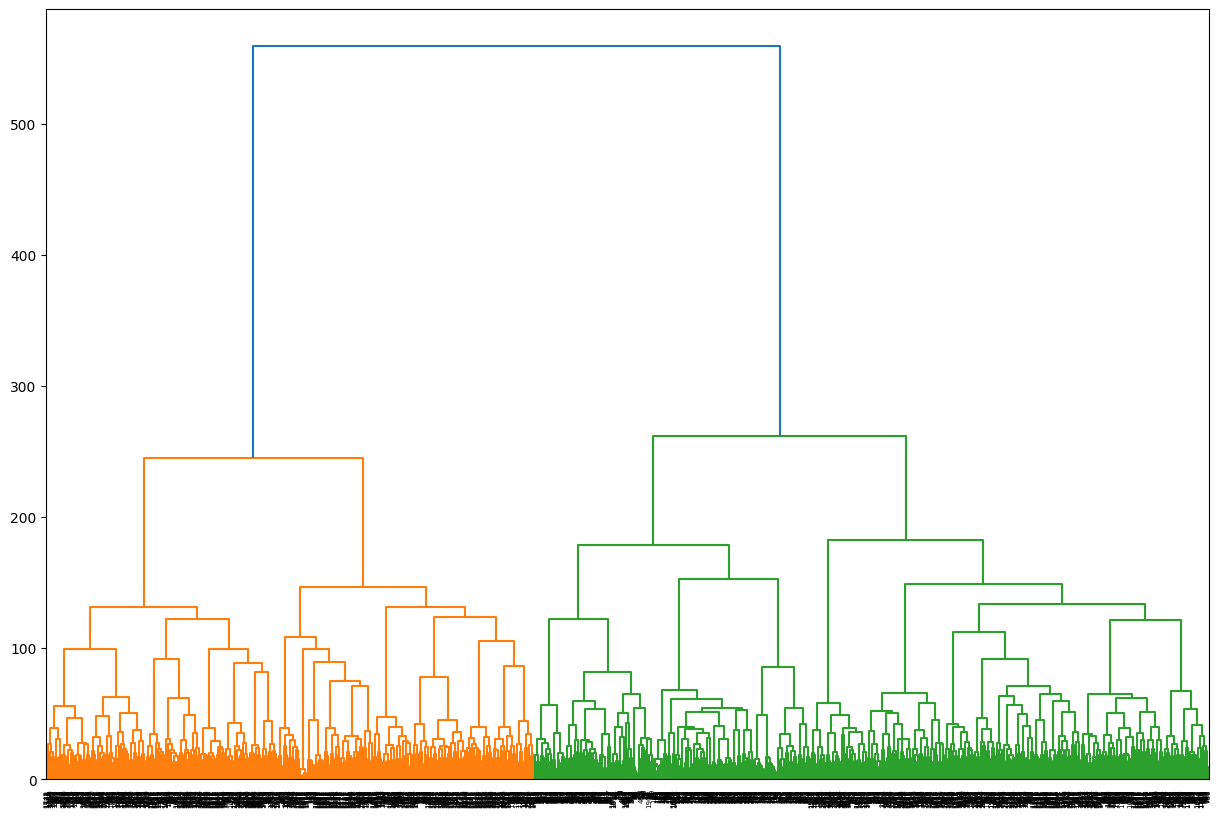

In [ ]:
"""
Dendrogram analysis

Compute the linkage matrix and plot a dendrogram.
"""
plt.figure(figsize=(15,10))
dend = shc.dendrogram(shc.linkage(vectors, method='ward'))
plt.show()

In [ ]:
# The number of clusters was picked following evaluation of various models using the silhouette score
cluster = AgglomerativeClustering(n_clusters=34, linkage='ward')
cluster.fit(vectors)
c_labels = cluster.labels_

In [ ]:
#| hide
vs_labelled = principal_df
vs_labelled['Cluster'] = list(c_labels)

# Picking a few clusters so they are more easily distinguished
test = vs_labelled.loc[(vs_labelled.loc[:,'Cluster'] == 0) | 
                       (vs_labelled.loc[:,'Cluster'] == 5) |
                       (vs_labelled.loc[:,'Cluster'] == 10)]

fig = px.scatter(test, 
                 x='PC0', y='PC1', 
                 hover_data={'Title': list(test.iloc[:, 0])},
                 color='Cluster',
                 color_continuous_scale=px.colors.sequential.Rainbow)

fig.layout.height = 500
fig.show()

## Plotting the Datasets on a Network Diagram

In [ ]:
#| hide
"""OLD CODE"""
# network_df = pd.DataFrame(columns=['Source', 'Target', 'weight'])

# for i in range(len(principal_df)):
    
#     labels = list(principal_df.iloc[:, 0].values)
#     ls, s_values = cos_similarity(principal_df, i, num=len(principal_df))

#     # s_values = (s_values - min(s_values))/(max(s_values) - min(s_values)) #* 3
    
#     source_labels = [labels[i]] * len(s_values)
#     updated_labels = labels
#     del updated_labels[i]
#     updated_labels = list(updated_labels)

#     temp_df = pd.DataFrame({'Source': source_labels, 'Target': updated_labels, 'weight': s_values})
#     temp_df = temp_df.sort_values(by='weight', ascending=False)#[:8] # taking top 5 most similar datasets to the one being compared
#     network_df = pd.concat([network_df, temp_df]).reset_index(drop=True)

'OLD CODE'

In [ ]:
"""
Creating a dataframe to be used to make a network diagram.

To do this we:
 - Go through every dataset
 - Get a list of the similarity between each dataset and every other dataset

The dataframe has a source, target, and weight columns. The similarity between the source and 
the target is the weight.
"""
network_df = pd.DataFrame(columns=['Source', 'Target', 'weight'])

for i in range(len(principal_df)):
    
    labels = list(principal_df.iloc[:, 0].values)
    ls, s_values = cos_similarity(principal_df.iloc[:, :-1], i, num=len(principal_df)-1)
    # ls, s_values = svm_similarity(principal_df.iloc[:, :-1], i, num=len(principal_df)-1)
    
    source_labels = [labels[i]] * len(s_values)
    
    temp_df = pd.DataFrame({'Source': source_labels, 'Target': ls, 'weight': s_values})
    temp_df = temp_df.sort_values(by='weight', ascending=False).head(5)
    network_df = pd.concat([network_df, temp_df]).reset_index(drop=True)

In [ ]:
# Removing connections with particularly low similarity values
net_df_outliers_removed = network_df.sort_values(by='weight', ascending=False)

mean = net_df_outliers_removed.weight.mean()
std = net_df_outliers_removed.weight.std()
net_df_outliers_removed = net_df_outliers_removed.loc[net_df_outliers_removed.weight > mean - 1.5*std].reset_index(drop=True) # remove values 1.5 standard deviations below the mean

net_df_outliers_removed['weight'] = net_df_outliers_removed['weight']/200

#### Histogram of the Weights

In [ ]:
fig = px.histogram(net_df_outliers_removed, x='weight', nbins=25)
fig.layout.height = 500
fig.show()

#### A network diagram using plotly

In [ ]:
#| hide
import networkx as nx
import plotly.graph_objects as go
from math import sqrt

In [ ]:
#| hide
# Random sample (of the top 5 most similar datasets for each dataset)
# new_data = network_df#.sample(500) 
new_data = net_df_outliers_removed.head(7500)
show_edges = True # Change to True to show edges (slower)

G = nx.from_pandas_edgelist(new_data,
                            source='Source',
                            target='Target',
                            edge_attr='weight')

""" Plot network diagram """
node_sizes = [min(len(list(G.edges(node)))*0.2+6, 12) for node in G.nodes()]

# Set the positions of the nodes
pos = nx.spring_layout(G, k=1.2/sqrt(len(node_sizes)), seed=42)

if show_edges:
    # Create a list to store the edge traces
    edge_traces = []

    # Create an edge trace for each edge with varying width
    for u, v, d in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        width = d['weight']*0.5

        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=width, color='gray'),
            hoverinfo='none',
            mode='lines'
        )

        edge_traces.append(edge_trace)

# Create a node trace
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    text=[node for node in G.nodes()],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=node_sizes,
        size=node_sizes # The size of the node depends on the number of edges connected to it
    )
)

if show_edges:
    data = edge_traces + [node_trace]
else:
    data = node_trace

# Create the network graph figure
fig = go.Figure(data=data,
                layout=go.Layout(
                    title='',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
            )

# Display the network graph
fig.layout.height = 750
fig.show()

#### A 3D Network Diagram using Plotly

In [ ]:
#| hide
new_data = net_df_outliers_removed.head(5000)

G = nx.from_pandas_edgelist(new_data, source='Source', target='Target', edge_attr='weight')

# Set the positions of the nodes in 3D space
pos = nx.spring_layout(G, dim=3, k=1.2/sqrt(len(G.nodes())), seed=42)

# Create a list to store the edge traces
edge_traces = []

# Create an edge trace for each edge with varying width
for u, v, d in G.edges(data=True):
    x0, y0, z0 = pos[u]
    x1, y1, z1 = pos[v]
    width = d['weight'] * 0.5

    edge_trace = go.Scatter3d(
        x=[x0, x1, None],
        y=[y0, y1, None],
        z=[z0, z1, None],
        line=dict(width=width, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    edge_traces.append(edge_trace)

# Create a node trace
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    z=[pos[node][2] for node in G.nodes()],
    text=[node for node in G.nodes()],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=node_sizes,
        size=node_sizes  # The size of the node depends on the number of edges connected to it
    )
)

# Combine edge traces and node trace
data = node_trace #edge_traces + [node_trace]

# Create the network graph figure
fig = go.Figure(data=data, layout=go.Layout(
    title='',
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    scene=dict(
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
))

# Display the network graph
fig.layout.height = 750
fig.show()



#### A Network Diagram Using Pyvis

In [ ]:
#| hide
#| export
from pyvis.network import Network
from IPython.display import display

In [ ]:
#| hide
new_data = net_df_outliers_removed
G = nx.from_pandas_edgelist(new_data.head(2000), #.sample(1000),
                            source='Source',
                            target='Target',
                            edge_attr='weight')

net = Network(notebook=True)

# Configure the layout
net.set_options("""
    {
      "layout": {
        "randomSeed": 2,
        "improvedLayout": true,
        "forceAtlas2Based": {
          "gravitationalConstant": -200,
          "springConstant": 0.05,
          "damping": 0.4,
          "avoidOverlap": 1,
          "centralGravity": 0.01
        },
        "hierarchical": {
          "enabled": false
        }
      },
      "interaction": {
        "hover": true
      }
    }
""")

# Generate the network visualization
net.from_nx(G)
net.show("network.html")